# SC4002 / CE4045 / CZ4045 NLP — Part 3.3: Enhancements

This notebook reuses the serialized TREC pipeline prepared in Part 3.1 and improves the base model specified in part 2.

## Setup

Import the same dependencies used in the biLSTM/biGRU notebook so the experiment can plug into the shared data loaders and utilities.

In [13]:
import sys, os, math, random, time
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from collections import defaultdict

import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 888
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Data & Vocab Loading

Load the serialized torchtext artifacts so the iterators, vocabulary, and pretrained embeddings exactly match the previous experiments.

In [14]:
LOAD_PREPARED = True

if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")

    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])

    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}

    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    PAD_IDX = TEXT.vocab.stoi.get(TEXT.pad_token, 0)
    print("Artifacts loaded.")
else:
    raise RuntimeError("Set LOAD_PREPARED=True to reuse the serialized pipeline.")

Artifacts loaded.


## Training Utilities

Utility functions copied from the biLSTM/biGRU notebook so the training/evaluation logic stays consistent.

In [15]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


def _extract_batch(batch):
    if hasattr(batch, 'text'):
        text, lengths = batch.text
        labels = batch.label
    else:
        text, lengths, labels = batch
    if text.dim() == 2 and text.size(0) != lengths.size(0):
        text = text.transpose(0, 1)  # -> [batch, seq_len]
    return text, lengths, labels


def train_loop(model, iterator, optimizer, criterion, grad_clip=None, max_norm=1.0):
    model.train()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    for batch in iterator:
        text, lengths, labels = _extract_batch(batch)

        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits, labels)
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_examples += labels.size(0)
        total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def eval_loop(model, iterator, criterion):
    model.eval()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
            total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def test_loop(model, iterator):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / max(total_examples, 1)


def topic_eval_loop(model, iterator, label_vocab):
    model.eval()
    n = len(label_vocab.itos)
    correct = [0] * n
    total = [0] * n
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            preds = torch.argmax(logits, dim=1)
            for p, y in zip(preds.tolist(), labels.tolist()):
                total[y] += 1
                correct[y] += int(p == y)
    per_topic = {}
    for idx, lab in enumerate(label_vocab.itos):
        if total[idx] == 0:
            per_topic[lab] = float('nan')
        else:
            per_topic[lab] = correct[idx] / total[idx]
    return per_topic

## Enhancement Methodology

Model A implements an RNN with additive attention pooling (single- and multi-head variants).
Model B adds a self-attention pooling block on top of the recurrent encoder.
Model C mixes convolutional features with the recurrent backbone before attention pooling.
Model D swaps the recurrent encoder for a lightweight Transformer to explore a non-RNN baseline.


TODO ADD MARKDOWN LATER


In [40]:

class AttentionPooling(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, attn_dim)
        self.score = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, rnn_outputs, mask):
        scores = self.score(torch.tanh(self.proj(rnn_outputs))).squeeze(-1)
        scores = scores.masked_fill(~mask, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs).squeeze(1)
        return context, attn_weights


class MultiHeadAttentionPooling(nn.Module):
    def __init__(self, input_dim, attn_dim, num_heads, merge='concat'):
        super().__init__()
        if num_heads < 2:
            raise ValueError("num_heads must be >= 2 for multi-head attention.")
        if attn_dim % num_heads != 0:
            raise ValueError("attn_dim must be divisible by num_heads for multi-head attention.")
        if merge not in {'concat', 'mean'}:
            raise ValueError("merge must be either 'concat' or 'mean'.")
        self.num_heads = num_heads
        self.merge = merge
        self.proj = nn.Linear(input_dim, attn_dim)
        self.score = nn.Linear(attn_dim, num_heads, bias=False)
        if merge == 'concat':
            self.out_proj = nn.Linear(input_dim * num_heads, input_dim)
        else:
            self.out_proj = None

    def forward(self, rnn_outputs, mask):
        proj = torch.tanh(self.proj(rnn_outputs))  # [batch, seq_len, attn_dim]
        scores = self.score(proj)  # [batch, seq_len, num_heads]
        scores = scores.masked_fill(~mask.unsqueeze(-1), -1e9)
        attn_weights = torch.softmax(scores, dim=1)  # [batch, seq_len, num_heads]
        weighted = torch.matmul(attn_weights.transpose(1, 2), rnn_outputs)  # [batch, num_heads, input_dim]
        if self.merge == 'concat':
            context = self.out_proj(weighted.reshape(weighted.size(0), -1))
        else:
            context = weighted.mean(dim=1)
        return context, attn_weights


class SelfAttentionPooling(nn.Module):
    def __init__(self, input_dim, num_heads=4, dropout=0.1):
        super().__init__()
        if num_heads < 1:
            raise ValueError("num_heads must be >= 1 for self-attention pooling.")
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads.")
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.q_proj = nn.Linear(input_dim, input_dim)
        self.k_proj = nn.Linear(input_dim, input_dim)
        self.v_proj = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(input_dim, input_dim)

    def forward(self, rnn_outputs, mask):
        batch_size, seq_len, feat_dim = rnn_outputs.size()
        q = self.q_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(rnn_outputs).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        key_mask = ~mask.unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(key_mask, -1e9)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attended = torch.matmul(attn_weights, v)  # [batch, heads, seq_len, head_dim]
        query_mask = mask.unsqueeze(1).unsqueeze(-1)
        attended = attended * query_mask
        denom = query_mask.sum(dim=2).clamp_min(1.0)
        context = attended.sum(dim=2) / denom
        context = context.transpose(1, 2).reshape(batch_size, -1)
        context = self.out_proj(context)

        avg_weights = attn_weights.mean(dim=1)  # [batch, seq_len, seq_len]
        valid = mask.float()
        weighted_sum = (avg_weights * valid.unsqueeze(-1)).sum(dim=1)
        counts = valid.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled_weights = (weighted_sum / counts) * valid
        return context, pooled_weights


class AttentionRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, attn_dim=128, num_heads=1,
                 multihead_merge='concat', padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.num_heads = max(1, num_heads)
        if self.num_heads == 1:
            self.attention = AttentionPooling(feat_dim, attn_dim)
        else:
            self.attention = MultiHeadAttentionPooling(feat_dim, attn_dim, self.num_heads, merge=multihead_merge)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(embedded, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.attention(outputs, mask)
        self.last_attention = attn_weights

        logits = self.fc(self.dropout(context))
        return logits


class SelfAttentionRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, num_heads=4, padding_idx=0,
                 self_attn_dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        self.self_attn = SelfAttentionPooling(feat_dim, num_heads=num_heads, dropout=self_attn_dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(embedded, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.self_attn(outputs, mask)
        self.last_attention = attn_weights

        logits = self.fc(self.dropout(context))
        return logits


class CNNRNNWithAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5,
                 rnn_type='gru', bidirectional=False, attn_dim=128, num_heads=1,
                 conv_channels=128, kernel_sizes=(3, 5), padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.kernel_sizes = kernel_sizes
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(emb_dim, conv_channels, ks, padding=ks // 2)
            for ks in kernel_sizes
        ])
        conv_out_dim = conv_channels * len(kernel_sizes)

        rnn_type = rnn_type.lower()
        if rnn_type == 'gru':
            rnn_cls = nn.GRU
        elif rnn_type == 'lstm':
            rnn_cls = nn.LSTM
        elif rnn_type == 'rnn':
            rnn_cls = nn.RNN
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        self.rnn = rnn_cls(
            conv_out_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        feat_dim = hidden_dim * (2 if bidirectional else 1)
        if num_heads == 1:
            self.attention = AttentionPooling(feat_dim, attn_dim)
        else:
            self.attention = MultiHeadAttentionPooling(feat_dim, attn_dim, num_heads=num_heads)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(feat_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        conv_in = embedded.transpose(1, 2)
        conv_features = [torch.relu(conv(conv_in)) for conv in self.conv_layers]
        conv_cat = torch.cat(conv_features, dim=1).transpose(1, 2)

        lengths_cpu = lengths.detach().cpu()
        packed = pack_padded_sequence(conv_cat, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        lengths_device = lengths.to(outputs.device)
        mask = torch.arange(outputs.size(1), device=outputs.device).unsqueeze(0) < lengths_device.unsqueeze(1)

        context, attn_weights = self.attention(outputs, mask)
        self.last_attention = attn_weights

        logits = self.fc(self.dropout(context))
        return logits


class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * (-math.log(10000.0) / emb_dim))
        pe = torch.zeros(max_len, emb_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes, num_layers=2, nhead=4,
                 dim_feedforward=256, dropout=0.1, attn_dim=128, embeddings=None,
                 freeze_embeddings=False, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        if embeddings is not None:
            if not torch.is_tensor(embeddings):
                embeddings = torch.tensor(embeddings)
            if embeddings.size(1) != emb_dim:
                raise ValueError(
                    f"Embedding dimension mismatch: got {embeddings.size(1)} vs emb_dim={emb_dim}"
                )
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.pos_encoder = PositionalEncoding(emb_dim, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention = AttentionPooling(emb_dim, attn_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(emb_dim, num_classes)
        self.last_attention = None

    def forward(self, text, lengths):
        if text.dim() == 3:
            text = text.squeeze(0)
        if text.dim() == 2 and text.size(0) != lengths.size(0):
            text = text.transpose(0, 1)

        embedded = self.embedding(text)
        embedded = self.pos_encoder(embedded)

        lengths_device = lengths.to(embedded.device)
        mask = torch.arange(embedded.size(1), device=embedded.device).unsqueeze(0) < lengths_device.unsqueeze(1)
        src_key_padding_mask = ~mask

        encoded = self.encoder(embedded, src_key_padding_mask=src_key_padding_mask)
        context, attn_weights = self.attention(encoded, mask)
        self.last_attention = attn_weights
        logits = self.fc(self.dropout(context))
        return logits


In [41]:

EMB_DIM = pretrained_embeddings.size(1) if pretrained_embeddings is not None else 100
HIDDEN_DIM = 128
NUM_LAYERS = 1
ATTN_DIM = 128
DROPOUT = 0.5
RNN_TYPE = 'gru'
BIDIRECTIONAL = False
LR = 1e-3
EPOCHS = 40
PATIENCE = 4
GRAD_CLIP = 1.0
FREEZE_EMB = False
WEIGHT_DECAY = 0.0

EXPERIMENTS = [
    {
        "name": "model_a_single",
        "label": "Model A — Single-head attention RNN",
        "group": "Model A",
        "model_type": "attn_rnn",
        "num_heads": 1,
        "attn_dim": ATTN_DIM,
        "multihead_merge": "concat",
        "best_path": "attn_rnn_best.pt",
        "history_path": "attn_rnn_history.npz",
        "is_baseline": True,
    },
    {
        "name": "model_b_self_attn",
        "label": "Model B — Self-attention RNN",
        "group": "Model B",
        "model_type": "self_attn_rnn",
        "num_heads": 4,
        "attn_dim": ATTN_DIM,
        "best_path": "selfattn_rnn_best.pt",
        "history_path": "selfattn_rnn_history.npz",
        "self_attn_dropout": 0.1,
    },
    {
        "name": "model_c_cnn_rnn",
        "label": "Model C — CNN + RNN + attention",
        "group": "Model C",
        "model_type": "cnn_rnn_attn",
        "num_heads": 1,
        "attn_dim": ATTN_DIM,
        "conv_channels": 128,
        "kernel_sizes": (3, 5),
        "best_path": "cnnrnn_attn_best.pt",
        "history_path": "cnnrnn_attn_history.npz",
    },
    {
        "name": "model_d_transformer",
        "label": "Model D — Transformer encoder + attention",
        "group": "Model D",
        "model_type": "transformer",
        "nhead": 4,
        "num_layers": 2,
        "dim_feedforward": 256,
        "attn_dim": ATTN_DIM,
        "best_path": "transformer_attn_best.pt",
        "history_path": "transformer_attn_history.npz",
    },
]

vocab_size = len(TEXT.vocab)
num_classes = len(LABEL.vocab)
print(f"vocab_size={vocab_size}, num_classes={num_classes}, pad_idx={PAD_IDX}")

emb_matrix = pretrained_embeddings if pretrained_embeddings is not None else None
if emb_matrix is not None and emb_matrix.size(1) != EMB_DIM:
    raise ValueError(f"Embedding dim mismatch: {emb_matrix.size(1)} vs EMB_DIM={EMB_DIM}")

def build_model(exp_cfg):
    model_type = exp_cfg.get('model_type', 'attn_rnn')
    common_kwargs = dict(
        vocab_size=vocab_size,
        emb_dim=EMB_DIM,
        num_classes=num_classes,
        embeddings=emb_matrix,
        freeze_embeddings=FREEZE_EMB,
    )
    if model_type == 'attn_rnn':
        return AttentionRNNClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            num_heads=exp_cfg.get('num_heads', 1),
            multihead_merge=exp_cfg.get('multihead_merge', 'concat'),
            padding_idx=PAD_IDX,
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'self_attn_rnn':
        return SelfAttentionRNNClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            num_heads=exp_cfg.get('num_heads', 4),
            padding_idx=PAD_IDX,
            self_attn_dropout=exp_cfg.get('self_attn_dropout', 0.1),
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'cnn_rnn_attn':
        return CNNRNNWithAttentionClassifier(
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT,
            rnn_type=RNN_TYPE,
            bidirectional=BIDIRECTIONAL,
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            num_heads=exp_cfg.get('num_heads', 1),
            conv_channels=exp_cfg.get('conv_channels', 128),
            kernel_sizes=exp_cfg.get('kernel_sizes', (3, 5)),
            padding_idx=PAD_IDX,
            **common_kwargs,
        ).to(DEVICE)
    elif model_type == 'transformer':
        return TransformerClassifier(
            dropout=DROPOUT,
            num_layers=exp_cfg.get('num_layers', 2),
            nhead=exp_cfg.get('nhead', 4),
            dim_feedforward=exp_cfg.get('dim_feedforward', 256),
            attn_dim=exp_cfg.get('attn_dim', ATTN_DIM),
            padding_idx=PAD_IDX,
            **common_kwargs,
        ).to(DEVICE)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

criterion = nn.CrossEntropyLoss()

for exp in EXPERIMENTS:
    print(f"- {exp['label']} -> checkpoint: {exp['best_path']}")


vocab_size=8093, num_classes=6, pad_idx=1
- Model A — Single-head attention RNN -> checkpoint: attn_rnn_best.pt
- Model B — Self-attention RNN -> checkpoint: selfattn_rnn_best.pt
- Model C — CNN + RNN + attention -> checkpoint: cnnrnn_attn_best.pt
- Model D — Transformer encoder + attention -> checkpoint: transformer_attn_best.pt


In [42]:

RUN_EXPERIMENTS = None  # e.g. ['model_b_self_attn'] to train a subset

experiment_histories = {}
experiment_summaries = {}

for exp in EXPERIMENTS:
    if RUN_EXPERIMENTS is not None and exp['name'] not in RUN_EXPERIMENTS:
        continue

    name = exp['name']
    print(f"\n=== Experiment: {exp['label']} ===")

    model = build_model(exp)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
    )

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = -1.0
    best_epoch = 0
    wait = 0

    start_time = time.perf_counter()
    for epoch in range(1, EPOCHS + 1):
        if hasattr(train_iter, 'init_epoch'):
            train_iter.init_epoch()
        tr_loss, tr_acc = train_loop(model, train_iter, optimizer, criterion, grad_clip=GRAD_CLIP, max_norm=GRAD_CLIP)

        if hasattr(valid_iter, 'init_epoch'):
            valid_iter.init_epoch()
        va_loss, va_acc = eval_loop(model, valid_iter, criterion)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(va_loss)
        history['val_acc'].append(va_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_epoch = epoch
            wait = 0
            torch.save(model.state_dict(), exp['best_path'])
            np.savez(exp['history_path'], **history)
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping triggered.")
                break

    elapsed = time.perf_counter() - start_time
    print(f"Best validation accuracy for {exp['label']}: {best_val_acc:.4f} (epoch {best_epoch}, {elapsed:.1f}s elapsed)")

    experiment_histories[name] = history
    experiment_summaries[name] = {
        'label': exp['label'],
        'group': exp['group'],
        'num_heads': exp.get('num_heads'),
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'best_path': exp['best_path'],
        'history_path': exp['history_path'],
        'description': exp.get('description', exp['label']),
    }



=== Experiment: Model A — Single-head attention RNN ===
Epoch 01 | Train Loss: 1.5286 | Train Acc: 0.3744 | Val Loss: 1.2288 | Val Acc: 0.5376
Epoch 02 | Train Loss: 0.9065 | Train Acc: 0.6788 | Val Loss: 0.6667 | Val Acc: 0.7596
Epoch 03 | Train Loss: 0.5298 | Train Acc: 0.8249 | Val Loss: 0.5196 | Val Acc: 0.8156
Epoch 04 | Train Loss: 0.3359 | Train Acc: 0.8955 | Val Loss: 0.5649 | Val Acc: 0.8294
Epoch 05 | Train Loss: 0.2402 | Train Acc: 0.9282 | Val Loss: 0.4661 | Val Acc: 0.8633
Epoch 06 | Train Loss: 0.1657 | Train Acc: 0.9546 | Val Loss: 0.5159 | Val Acc: 0.8560
Epoch 07 | Train Loss: 0.1073 | Train Acc: 0.9716 | Val Loss: 0.5078 | Val Acc: 0.8569
Epoch 08 | Train Loss: 0.0801 | Train Acc: 0.9805 | Val Loss: 0.6130 | Val Acc: 0.8550
Epoch 09 | Train Loss: 0.0467 | Train Acc: 0.9890 | Val Loss: 0.5366 | Val Acc: 0.8688
Epoch 10 | Train Loss: 0.0336 | Train Acc: 0.9917 | Val Loss: 0.5838 | Val Acc: 0.8734
Epoch 11 | Train Loss: 0.0250 | Train Acc: 0.9952 | Val Loss: 0.5672 | Va

/Users/rachelkoh/Documents/NLP/SC4002-NLP/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | Train Loss: 1.6360 | Train Acc: 0.2820 | Val Loss: 1.4271 | Val Acc: 0.4303
Epoch 02 | Train Loss: 1.4202 | Train Acc: 0.4232 | Val Loss: 1.1685 | Val Acc: 0.5578
Epoch 03 | Train Loss: 1.1809 | Train Acc: 0.5420 | Val Loss: 0.7878 | Val Acc: 0.7073
Epoch 04 | Train Loss: 0.9834 | Train Acc: 0.6311 | Val Loss: 0.7680 | Val Acc: 0.7202
Epoch 05 | Train Loss: 0.9052 | Train Acc: 0.6667 | Val Loss: 0.6580 | Val Acc: 0.7615
Epoch 06 | Train Loss: 0.8341 | Train Acc: 0.6953 | Val Loss: 0.6265 | Val Acc: 0.7780
Epoch 07 | Train Loss: 0.7455 | Train Acc: 0.7306 | Val Loss: 0.6440 | Val Acc: 0.7927
Epoch 08 | Train Loss: 0.6850 | Train Acc: 0.7595 | Val Loss: 0.6129 | Val Acc: 0.7927
Epoch 09 | Train Loss: 0.6307 | Train Acc: 0.7856 | Val Loss: 0.5605 | Val Acc: 0.8156
Epoch 10 | Train Loss: 0.5857 | Train Acc: 0.7934 | Val Loss: 0.7336 | Val Acc: 0.8018
Epoch 11 | Train Loss: 0.5526 | Train Acc: 0.8173 | Val Loss: 0.6099 | Val Acc: 0.8220
Epoch 12 | Train Loss: 0.5101 | Train Acc: 

In [43]:

comparison_rows = []
per_topic_metrics = {}

baseline_row = None

for exp in EXPERIMENTS:
    name = exp['name']
    path = Path(exp['best_path'])
    if not path.exists():
        print(f"Skipping {exp['label']} — checkpoint not found at {path}.")
        continue

    model = build_model(exp)
    state_dict = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)

    if hasattr(test_iter, 'init_epoch'):
        test_iter.init_epoch()
    te_loss, te_acc = eval_loop(model, test_iter, criterion)
    if hasattr(test_iter, 'init_epoch'):
        test_iter.init_epoch()
    per_topic = topic_eval_loop(model, test_iter, LABEL.vocab)

    row = {
        'name': name,
        'label': exp['label'],
        'group': exp['group'],
        'test_loss': te_loss,
        'test_acc': te_acc,
        'checkpoint': str(path),
    }
    comparison_rows.append(row)
    per_topic_metrics[name] = per_topic
    experiment_summaries.setdefault(name, {}).update({
        'test_loss': te_loss,
        'test_acc': te_acc,
        'label': exp['label'],
        'group': exp['group'],
    })

    if exp.get('is_baseline'):
        baseline_row = row

    print(f"{exp['label']} -> Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.4f}")
    print("  Per-topic accuracy:")
    for label, score in per_topic.items():
        if math.isnan(score):
            print(f"    {label}: nan")
        else:
            print(f"    {label}: {score:.4f}")

if baseline_row is not None:
    base_acc = baseline_row['test_acc']
    print(f"Baseline: {baseline_row['label']} (Acc={base_acc:.4f})")
    for row in comparison_rows:
        if row['name'] == baseline_row['name']:
            continue
        delta = row['test_acc'] - base_acc
        print(f"Δ Test Acc vs baseline for {row['label']}: {delta:+.4f}")


Model A — Single-head attention RNN -> Test Loss: 0.4396 | Test Acc: 0.8980
  Per-topic accuracy:
    HUM: 0.9231
    ENTY: 0.7340
    DESC: 0.9638
    NUM: 0.9292
    LOC: 0.9259
    ABBR: 0.7778
Model B — Self-attention RNN -> Test Loss: 0.3845 | Test Acc: 0.9000
  Per-topic accuracy:
    HUM: 0.9385
    ENTY: 0.7447
    DESC: 0.9783
    NUM: 0.9204
    LOC: 0.9012
    ABBR: 0.7778
Model C — CNN + RNN + attention -> Test Loss: 0.4178 | Test Acc: 0.9160
  Per-topic accuracy:
    HUM: 0.9692
    ENTY: 0.8085
    DESC: 0.9638
    NUM: 0.9381
    LOC: 0.9136
    ABBR: 0.6667
Model D — Transformer encoder + attention -> Test Loss: 0.3992 | Test Acc: 0.8780
  Per-topic accuracy:
    HUM: 0.8923
    ENTY: 0.7021
    DESC: 0.9855
    NUM: 0.8584
    LOC: 0.9383
    ABBR: 0.6667
Baseline: Model A — Single-head attention RNN (Acc=0.8980)
Δ Test Acc vs baseline for Model B — Self-attention RNN: +0.0020
Δ Test Acc vs baseline for Model C — CNN + RNN + attention: +0.0180
Δ Test Acc vs baseline fo

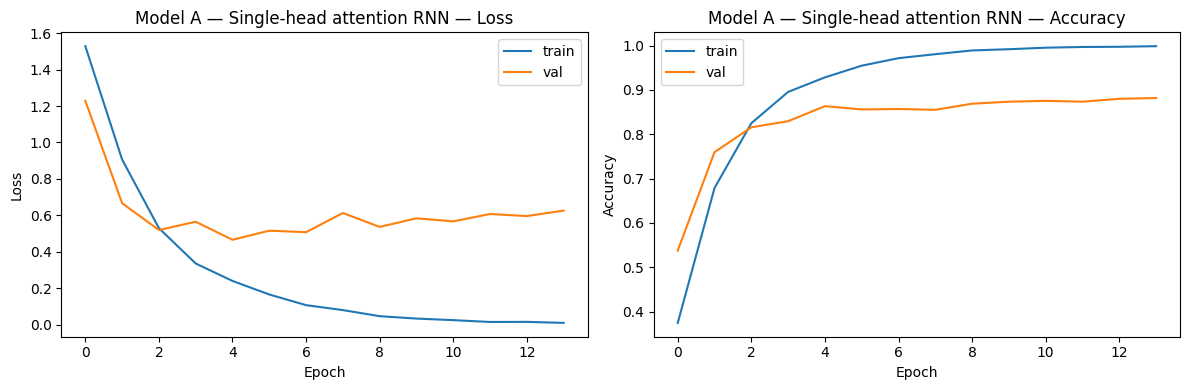

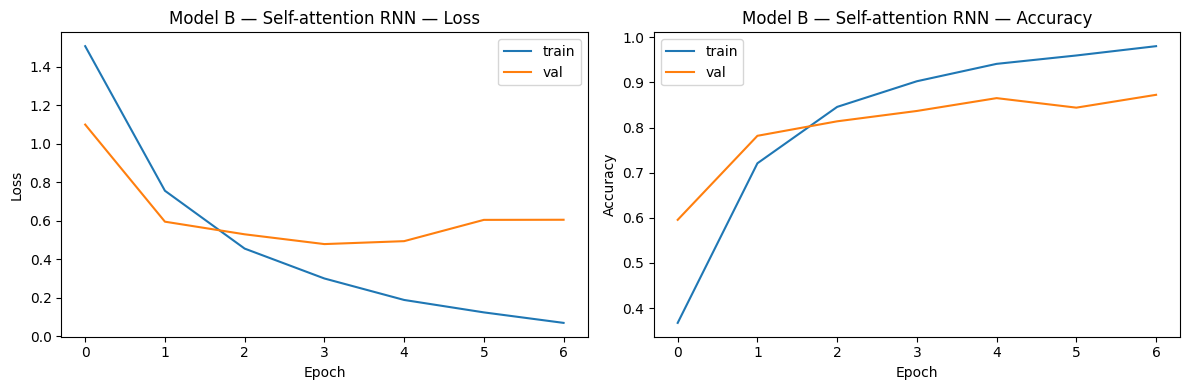

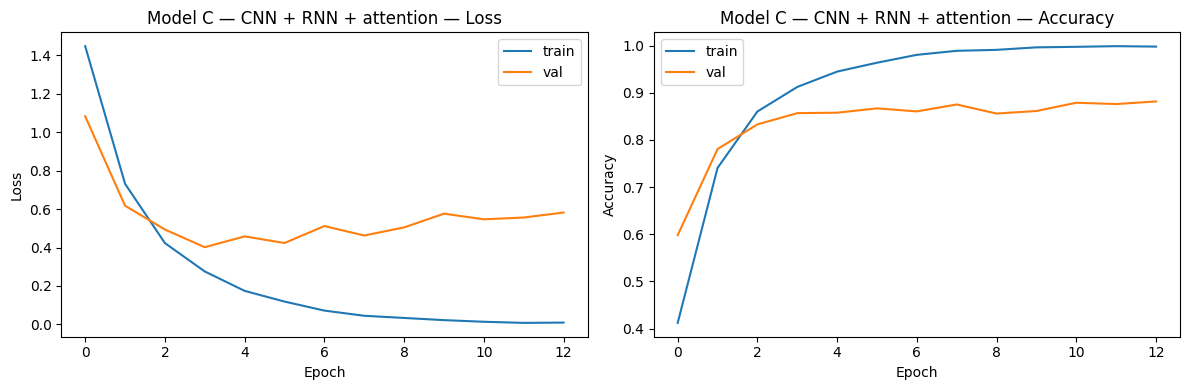

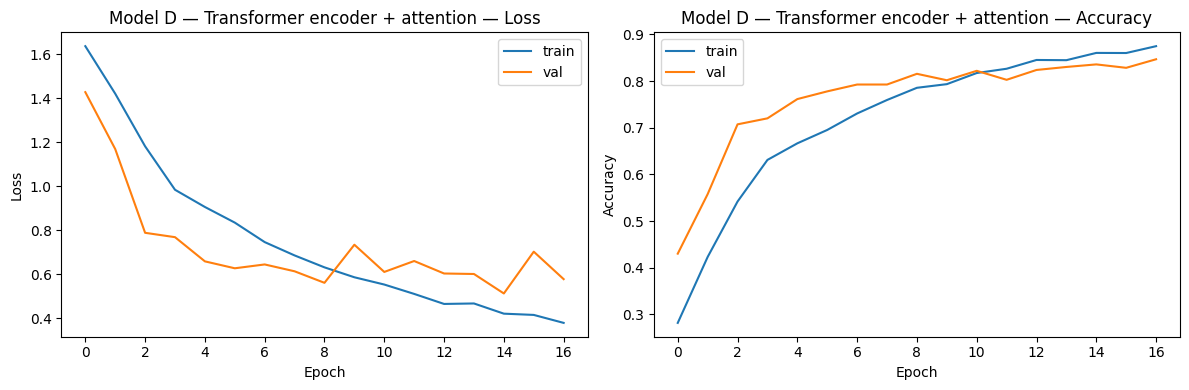

In [44]:

plotted_any = False

for exp in EXPERIMENTS:
    history_path = Path(exp['history_path'])
    if not history_path.exists():
        print(f"History not found for {exp['label']} at {history_path}.")
        continue

    data = np.load(history_path, allow_pickle=True)
    train_loss = data['train_loss']
    train_acc = data['train_acc']
    val_loss = data['val_loss']
    val_acc = data['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='val')
    axes[0].set_title(f"{exp['label']} — Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='val')
    axes[1].set_title(f"{exp['label']} — Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plotted_any = True

if not plotted_any:
    print("No saved histories found yet. Train an experiment to populate the plots.")
